In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import signal

In [6]:
GMST = pd.read_csv("GMST.csv",header=None)
datas = pd.date_range("1880-1",periods=1736,freq="MS")
datas
GMST.index = datas
GMST.columns=["GMST"]
GMST1 = GMST["1950":"2022"]
data = pd.read_csv("data1.csv",index_col=0)
data.index = GMST1.index
data = pd.concat([data,GMST1],names=[data.columns,GMST],axis=1)
data

,DMI,AO,AMON,NAO,NINO,PDO,GMST
1950-01-01,-0.044,-0.060,0.105,0.55,-1.5,-1.61,-0.282360
1950-02-01,-0.554,0.627,-0.040,3.31,-1.3,-2.17,-0.292390
1950-03-01,-0.692,-0.008,-0.112,0.82,-1.2,-1.89,-0.072244
1950-04-01,-0.475,0.555,-0.137,1.61,-1.2,-1.99,-0.211210
1950-05-01,-0.309,0.072,-0.065,-1.73,-1.1,-3.19,-0.129560
...,...,...,...,...,...,...,...
2022-08-01,-0.246,-0.170,0.358,-1.70,-0.9,-2.38,0.972450
2022-09-01,-0.322,-0.655,0.662,-3.73,-1.0,-2.29,0.903820
2022-10-01,-0.691,1.346,0.483,0.86,-1.0,-1.81,1.000700
2022-11-01,-0.269,0.339,0.282,2.37,-0.9,-2.41,0.736360


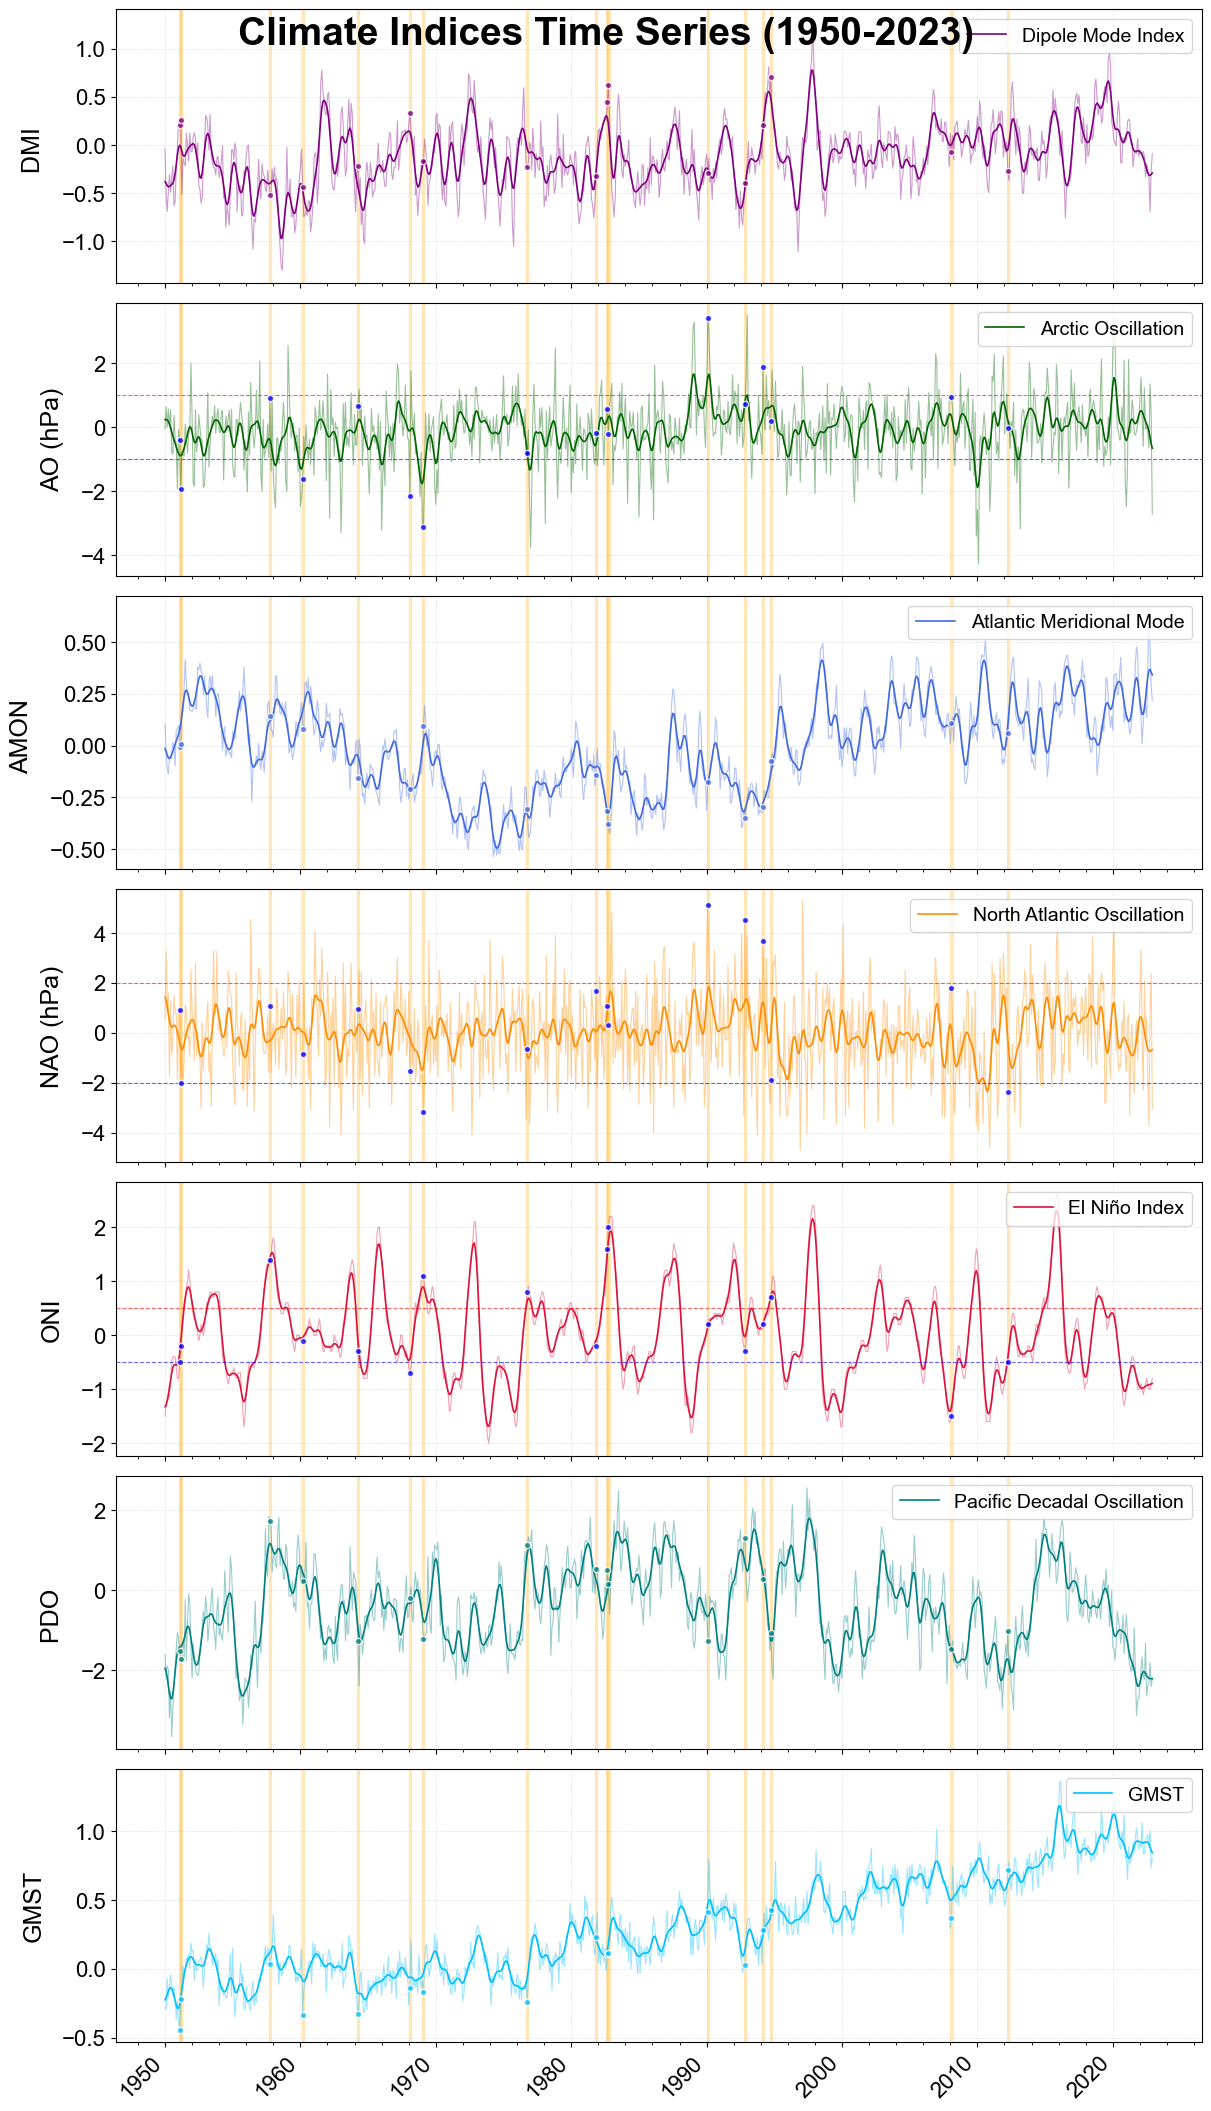

In [8]:
# 生成时间索引 (假设从1950年1月开始)
dates = pd.date_range("1950-01", periods=876, freq="MS")
data.index = dates
GMST1.index = dates
# =====================================
# 2. 滤波函数定义
# =====================================
def high_pass_filter(series, cutoff=1/120):
    b, a = signal.butter(4, cutoff, btype='high', fs=12)
    return signal.filtfilt(b, a, series)

def trenberth_smooth(series):
    if np.all(np.isnan(series)):
        return series
    
    valid_mask = ~np.isnan(series)
    ts0 = series[valid_mask]
    
    if len(ts0) == 0:
        return series
    
    weights = np.array([1,6,19,42,71,96,106,96,71,42,19,6,1]) / 576
    pad_size = len(weights) // 2  # 计算填充大小

    # 处理填充
    front_pad = ts0[:pad_size][::-1] if len(ts0) >= pad_size else ts0[::-1]
    end_pad = ts0[-pad_size:][::-1] if len(ts0) >= pad_size else ts0[::-1]
    
    ts_padded = np.concatenate([front_pad, ts0, end_pad])
    
    # 使用 'same' 模式保持输出长度一致
    smoothed = np.convolve(ts_padded, weights, mode='same')
    
    # 仅取回原始数据长度部分
    smoothed = smoothed[pad_size:-pad_size] if len(smoothed) > len(ts0) else smoothed

    smoothed_series = np.full_like(series, np.nan)
    smoothed_series[valid_mask] = smoothed
    
    return smoothed_series

data_filtered = data.apply(high_pass_filter)
data_smoothed = data.apply(trenberth_smooth)

# =====================================
# 3. 可视化设置
# =====================================
plt.rcParams.update({
    'font.sans-serif': 'Arial',
    'axes.labelsize': 18,
    'xtick.labelsize':16 ,
    'ytick.labelsize': 16,
    'axes.titlesize': 20,
    'figure.constrained_layout.use': True
})

fig, axes = plt.subplots(7, 1, figsize=(12, 21), sharex=True,
                        gridspec_kw={'hspace': 0.05})

# =====================================
# 4. 绘制各指数子图
# =====================================
def plot_climate_index(ax, series, color, label, ylabel, thresholds=None, highlight_indices=None):
    # 绘制原始数据
    ax.plot(series.index, series, color=color, lw=0.8, alpha=0.4)
    # 绘制平滑数据
    ax.plot(series.index, trenberth_smooth(series), 
           color=color, lw=1.2, label=label)
    
    # 标注阈值事件
    if thresholds:
        for threshold, color in thresholds.items():
            ax.axhline(threshold, color=color, ls='--', lw=0.8, alpha=0.6)
    
    # 新增：在指定位置添加点标记
    if highlight_indices is not None:
        # 获取时间点和对应的值
        highlight_dates = series.index[highlight_indices]
        highlight_values = series.iloc[highlight_indices]
        ax.scatter(highlight_dates, highlight_values, 
                   color=color, s=20, edgecolor='white', zorder=3, alpha=0.8)

    ax.set_ylabel(ylabel, labelpad=12)
    ax.grid(ls=':', lw=0.5, alpha=0.6)
    ax.legend(loc='upper right', fontsize=14)
highlight_indices = np.array( [13, 14, 93, 122, 171, 217, 229, 321, 382, 392, 393, 481, 514, 530, 537, 697, 747])
plot_climate_index(axes[6],GMST1.GMST,'deepskyblue',"GMST","GMST", highlight_indices=highlight_indices)
    
# DMI
plot_climate_index(axes[0], data.DMI, 'purple', 
                  'Dipole Mode Index', 'DMI ', highlight_indices=highlight_indices)

# AO
plot_climate_index(axes[1], data.AO, 'darkgreen', 
                  'Arctic Oscillation', 'AO (hPa)',
                  thresholds={1.0: 'red', -1.0: 'blue'}, highlight_indices=highlight_indices)

# AMON
plot_climate_index(axes[2], data.AMON, 'royalblue', 
                  'Atlantic Meridional Mode', 'AMON ', highlight_indices=highlight_indices)

# NAO
plot_climate_index(axes[3], data.NAO, 'darkorange', 
                  'North Atlantic Oscillation', 'NAO (hPa)',
                  thresholds={2.0: 'red', -2.0: 'blue'}, highlight_indices=highlight_indices)

# NINO3.4
plot_climate_index(axes[4], data.NINO, 'crimson', 
                  'El Niño Index', 'ONI',
                  thresholds={0.5: 'red', -0.5: 'blue'}, highlight_indices=highlight_indices)

# PDO
plot_climate_index(axes[5], data.PDO, 'teal', 
                  'Pacific Decadal Oscillation', 'PDO ', highlight_indices=highlight_indices)

# =====================================
# 5. 坐标轴格式调整
# =====================================
axes[-1].xaxis.set_major_locator(mdates.YearLocator(10))
axes[-1].xaxis.set_minor_locator(mdates.YearLocator(2))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')


datess = pd.date_range(start="1950-01-01", periods=876, freq="MS")

# 输入的索引数组
indices = np.array( [13, 14, 93, 122, 171, 217, 229, 321, 382, 392, 393, 481, 514, 530, 537, 697, 747])

# 转换为时间点并生成三个月范围
timestamps = datess[indices]
time_ranges = []
for ts in timestamps:
    start = ts - pd.DateOffset(months=1) if ts > datess[0] else ts
    end = ts + pd.DateOffset(months=1) if ts < datess[-1] else ts
    time_ranges.append((start, end))

# 绘制所有区域
for start, end in time_ranges:
    for ax in axes:
        ax.axvspan(start, end, color="orange", alpha=0.2, zorder=0)

# =====================================
# 6. 保存与显示
# =====================================
plt.suptitle("Climate Indices Time Series (1950-2023)", y=0.995, 
            fontsize=28, fontweight='bold')
plt.savefig('climate_indices.png', dpi=300, bbox_inches='tight')
plt.show()